In [19]:
import matplotlib.pyplot as plt
import numpy as np
from src.SIR.sir_model import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


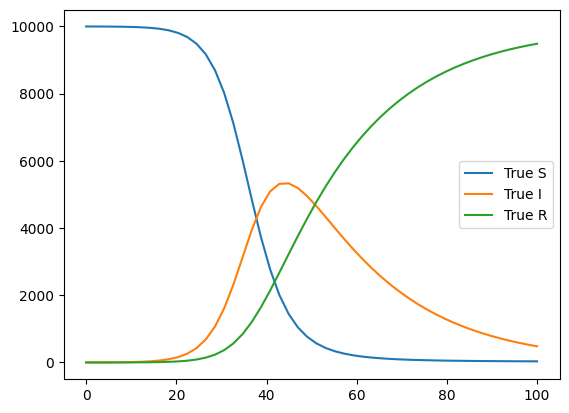

In [20]:
t = np.linspace(0, 100, 50)

S, I, R = simulate_sir(t)
plot_sir(S, I, R, t)

In [ ]:
I_data = I + np.random.normal(0, 0.01 * I, size=I.shape)

# initial guess
alpha0 = 0.00001
gamma0 = 0.01
S00 = 10

# plot initial values
print(f"Initial Values\n"
      f"initial alpha: {alpha0}"
      f"initial gamma: {gamma0}"
      f"initial S0: {S00}")

# no rescale
result = run_experiments(alpha0, gamma0, S00, I_data, t, rescale=False)
print("Without rescale")
print_results(result)

# rescale
result_ = run_experiments(alpha0, gamma0, S00, I_data, t, rescale=True)
print("With rescale")
print_results(result_)

# mul method
result__ = run_experiments_mul(alpha0, gamma0, S00, I_data, t)
print("mul method")
print_results(result__)

# plot
plot_three_results(result, result_, result__)

## Noise Level Analysis

In [ ]:
noise_steps = 41
noise_levels = [0.005 * i for i in range(noise_steps)]  # 0% to 20%
x_noise_percent = [0.5 * i for i in range(noise_steps)]

# initial guess for alpha and gamma and S0
alpha0 = 0.00001
gamma0 = 0.01
S00 = 6000
x0 = [alpha0, gamma0, S00]

num_of_iterations = 20

results = {
    "alpha": {"mean": [], "std": []},
    "gamma": {"mean": [], "std": []},
    "S0":   {"mean": [], "std": []}
}

for noise in noise_levels:
    alpha_results = []
    gamma_results = []
    S0_results = []
    for _ in range(num_of_iterations):
        I_data = I + np.random.normal(0, noise * I, size=I.shape)
        res = least_squares(residual, x0, args=(I_data, t), bounds=(0, np.inf), x_scale=scales)

        alpha_results.append(res.x[0])
        gamma_results.append(res.x[1])
        S0_results.append(res.x[2])

    results["alpha"]["mean"].append(np.mean(alpha_results))
    results["alpha"]["std"].append(np.std(alpha_results))

    results["gamma"]["mean"].append(np.mean(gamma_results))
    results["gamma"]["std"].append(np.std(gamma_results))

    results["S0"]["mean"].append(np.mean(S0_results))
    results["S0"]["std"].append(np.std(S0_results))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
params = ["alpha", "gamma", "S0"]
true_values = [alpha, gamma, S0]

for i, param in enumerate(params):
    ax = axes[i]
    means = np.array(results[param]["mean"])
    stds = np.array(results[param]["std"])

    # Plot Mean
    ax.plot(x_noise_percent, means, label=f"Estimated {param}", color="blue", marker="o", markersize=3)

    # Plot True Value
    ax.axhline(y=true_values[i], label=f"True {param}", color="orange", linestyle="--", linewidth=2)

    # Plot Standard Deviation
    ax.fill_between(x_noise_percent, means - stds, means + stds, color="blue", alpha=0.2, label="Std Dev")

    ax.set_title(f"Robustness of {param}")
    ax.set_xlabel("Noise Level (% of max I)")
    ax.set_ylabel("Parameter Value")
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()

## Number of Datapoints

In [ ]:
num_of_data_points = [1 * i for i in range(20, 101)]

# initial guess for alpha and gamma and S0
alpha0 = 0.00001
gamma0 = 0.01
S00 = 6000
x0 = [alpha0, gamma0, S00]

num_of_iterations = 20

results = {
    "alpha": {"mean": [], "std": []},
    "gamma": {"mean": [], "std": []},
    "S0":   {"mean": [], "std": []}
}

num_of_iterations = 20

for steps in num_of_data_points:
    t = np.linspace(0, 100, steps)
    S, I, R = simulate_sir(t)

    alpha_results = []
    gamma_results = []
    S0_results = []
    for _ in range(num_of_iterations):
        I_data = I + np.random.normal(0, 0.01 * I, size=I.shape)

        res = least_squares(residual, x0, args=(I_data, t), bounds=(0, np.inf), x_scale=scales)

        alpha_results.append(res.x[0])
        gamma_results.append(res.x[1])
        S0_results.append(res.x[2])

    results["alpha"]["mean"].append(np.mean(alpha_results))
    results["alpha"]["std"].append(np.std(alpha_results))

    results["gamma"]["mean"].append(np.mean(gamma_results))
    results["gamma"]["std"].append(np.std(gamma_results))

    results["S0"]["mean"].append(np.mean(S0_results))
    results["S0"]["std"].append(np.std(S0_results))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
param_names = ["alpha", "gamma", "S0"]
true_params = [alpha, gamma, S0]

for i, param in enumerate(param_names):
    ax = axes[i]
    means = np.array(results[param]["mean"])
    stds = np.array(results[param]["std"])

    # Plot Mean and True Value
    ax.plot(num_of_data_points, means, label=f"Estimated {param}", color="green", marker="o")
    ax.axhline(y=true_params[i], label=f"True {param}", color="orange", linestyle="--")

    # Plot Error Band
    ax.fill_between(num_of_data_points, means - stds, means + stds, color="green", alpha=0.2, label="Std Dev")

    ax.set_title(f"Sensitivity to Sampling Density: $\\{param}$")
    ax.set_xlabel("Number of Data Points ($N$)")
    ax.set_ylabel("Estimated Value")
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.set_xticks(num_of_data_points[::5])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()

## Simulate S

In [ ]:
I_data = I + np.random.normal(0, 0.01 * I, size=I.shape)

# initial guess for alpha and gamma and S0
alpha0 = 0.00001
gamma0 = 0.01
S00 = 6000
x0 = [alpha0, gamma0, S00]

res = least_squares(residual, x0, args=(I_data, t), bounds=(0, np.inf), x_scale=scales)
alpha_hat, gamma_hat, S0_hat = tuple(res.x)

# from the relationship equation
I_int = np.array([simpson(I_data[:i + 1], t[:i + 1]) for i in range(len(t))])
S_hat = S0_hat - I_data + I_data[0] - gamma_hat * I_int

# from numerical integration
solution_hat = scipy.integrate.odeint(SIR, [S0_hat, I_data[0], R0], t, args=(alpha_hat, gamma_hat))
S_hat_2 = solution_hat.T[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Direct Calculation ---
axes[0].plot(t, S_hat, label="Estimated S (Direct)", color='blue')
axes[0].plot(t, S, label="True S", color='black', linestyle='--')
axes[0].set_title("Simulate S from Direct Calculation")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Plot 2: Numerical Integration ---
axes[1].plot(t, S_hat_2, label="Estimated S (Num. Int.)", color='red')
axes[1].plot(t, S, label="True S", color='black', linestyle='--')
axes[1].set_title("Simulate S from Numerical Integration")
axes[1].set_xlabel("Time")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
S_hat_error = S_hat - S
S_hat_2_error = S_hat_2 - S

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Plot 1: Direct Calculation ---
axes[0].plot(t, S_hat_error, label="Error from Estimated S (Direct)", color='blue')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_title("Simulated S from Direct Calculation - True S")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Plot 2: Numerical Integration ---
axes[1].plot(t, S_hat_2_error, label="Error from Estimated S (Num. Int.)", color='red')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title("Simulated S from Numerical Integration - True S")
axes[1].set_xlabel("Time")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

#plt.suptitle("S-Parameter Estimation Error Analysis (Direct Errors)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# relative percentage errors
rel_error_1 = (S_hat - S) / S * 100
rel_error_2 = (S_hat_2 - S) / S * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

methods = [
    (rel_error_1, "Direct Calculation", "blue"),
    (rel_error_2, "Numerical Integration", "red")
]

for ax, (data, title, color) in zip(axes, methods):
    ax.plot(t, data, label=f"Relative Error", color=color, alpha=0.7)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Error (%)" if ax == axes[0] else "")
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()

#plt.suptitle("S-Parameter Estimation Error Analysis (Relative Percentage Errors)", fontsize=14)
plt.tight_layout()
plt.show()